In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch
import sys
import os
import sys
from pathlib import Path
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))
from src.model import *
from src.train import *
from src.utils import *
import pickle

## GPU

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cpu


## Load Dataset

In [27]:
transform = transforms.ToTensor() # it applies the normalization
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
# batching with size of 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

## Categories

In [28]:
categories = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_boot']

## Loss Function

In [29]:
# CrossEntropy is used for classification
criterion = torch.nn.CrossEntropyLoss()

## Models

In [37]:
# Define the directory and file path separately
records_dir = '../data'
records_path = os.path.join(records_dir, 'training_records.pkl')

if os.path.exists(records_path):
    print(f"Loading existing records from {records_path}...")
    all_records = torch.load(records_path, map_location=device, weights_only=False)
    record1 = all_records['record1']
    record2 = all_records['record2']
    record3 = all_records['record3']
    model1 = all_records['model1']
    model2 = all_records['model2']
    model3 = all_records['model3']
else:
    print("No existing records found. Starting training...")
    
    # Configuration 1: Baseline + SGD
    print("Training Configuration 1...")
    model1 = FashionClassifier_Baseline()
    opt_SGD = torch.optim.SGD(model1.parameters(), lr=0.01)
    record1 = train_model(model1, train_loader, test_loader, criterion, opt_SGD, device)

    # Configuration 2: 2Hidden + Adam
    print("Training Configuration 2...")
    model2 = FashionClassifier_2Hidden()
    opt_Adam = torch.optim.Adam(model2.parameters(), lr=0.001)
    record2 = train_model(model2, train_loader, test_loader, criterion, opt_Adam, device)

    # Configuration 3: 3Hidden + AdamW + Dropout
    print("Training Configuration 3...")
    model3 = FashionClassifier_3Hidden()
    opt_AdamW = torch.optim.AdamW(model3.parameters(), lr=0.001)
    record3 = train_model(model3, train_loader, test_loader, criterion, opt_AdamW, device)

    # Save all records to a single dictionary
    all_records = {
        'record1': record1,
        'record2': record2,
        'record3': record3,
        'model1': model1,
        'model2': model2,
        'model3': model3
    }
    
    if not os.path.exists(records_dir):
        os.makedirs(records_dir)
    torch.save(all_records, records_path)
    print(f"Training complete. Records saved to {records_path}.")

Loading existing records from ../data\training_records.pkl...


2 Hidden + Adam is the best model with the highest accuracy of both training and validation.

## Plot Confusion Matrix of the Best Model

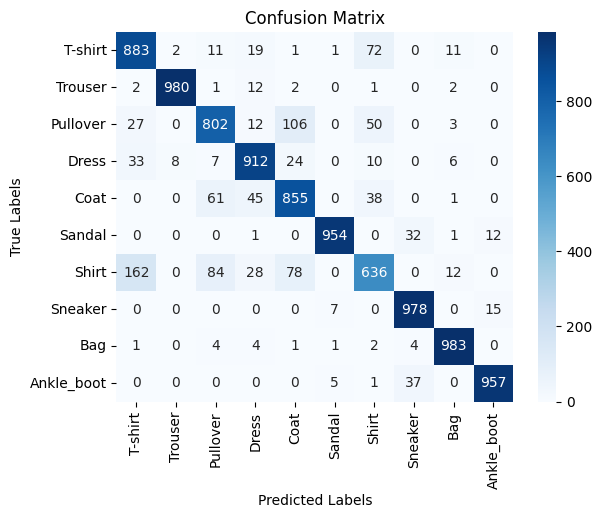

In [31]:
generate_confusion_matrix(model2, test_loader, criterion, device, categories)

## Plot Training Loss and Validation Accuracy

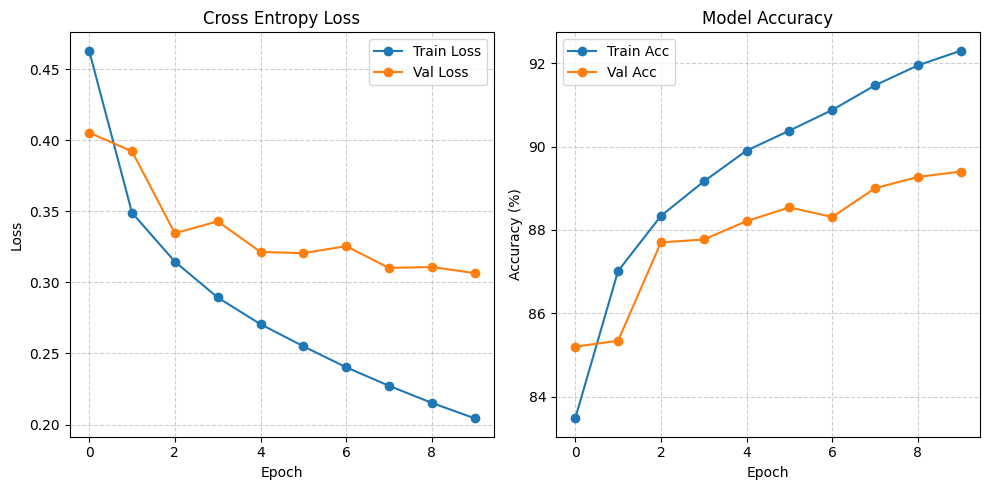

In [32]:
plot_training_results(record2[0], record2[1], record2[2], record2[3])

# Cost Matrix and Cost-weighted Accuracy

## Confidence Threshold Plot

In [33]:
thresholds, accuracy_scores, acceptance_rates = analyze_confidence_thresholds(model2, test_loader, device)

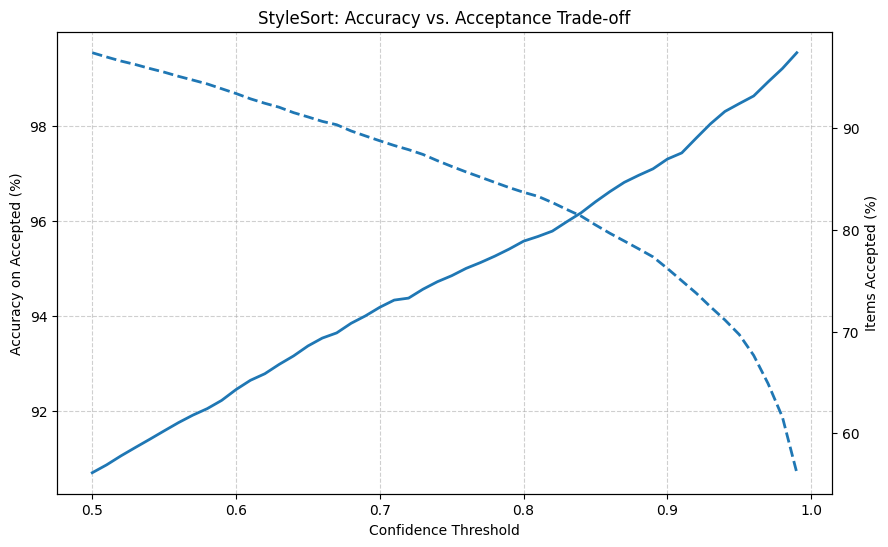

In [34]:
plot_confidence_analysis(thresholds, accuracy_scores, acceptance_rates)

## Misclassification Examples